## Datasets Used

This project uses VGChartz Video Game Sales Dataset (2024)
- Provides commercial performance indicators:
  - Total global sales
  - Regional sales (NA, JP, PAL, Other)
  - Critic scores
  - Release dates


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub

# Set display options
pd.set_option('display.max_columns', None)


## 1. Load Data


In [33]:
dataset_path = kagglehub.dataset_download("asaniczka/video-game-sales-2024")
csv_file = [f for f in os.listdir(dataset_path) if f.endswith('.csv')][0]
file_path = os.path.join(dataset_path, csv_file)

# load the dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at {file_path}. Please check the path.")


Dataset loaded successfully.


## 2. Basic Data Understanding
Here we check the data dimensions, types, and missing values.


In [34]:
# number of rows & columns
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

# first few rows
print("\nFirst 5 Rows:")
df.head()


Rows: 64016
Columns: 14

First 5 Rows:


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


In [35]:
# data types
print("Data Types:")
print(df.dtypes)

# Identify numeric vs categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")

# statistics for numeric columns
print("\nStatistics for Numeric Columns:")
df[numeric_cols].describe()


Data Types:
img              object
title            object
console          object
genre            object
publisher        object
developer        object
critic_score    float64
total_sales     float64
na_sales        float64
jp_sales        float64
pal_sales       float64
other_sales     float64
release_date     object
last_update      object
dtype: object

Numeric columns (6): ['critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales']

Categorical columns (8): ['img', 'title', 'console', 'genre', 'publisher', 'developer', 'release_date', 'last_update']

Statistics for Numeric Columns:


,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,6678.000000,18922.000000,12637.000000,6726.000000,12824.000000,15128.000000
mean,7.220440,0.349113,0.264740,0.102281,0.149472,0.043041
std,1.457066,0.807462,0.494787,0.168811,0.392653,0.126643
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.400000,0.030000,0.050000,0.020000,0.010000,0.000000
50%,7.500000,0.120000,0.120000,0.040000,0.040000,0.010000
75%,8.300000,0.340000,0.280000,0.120000,0.140000,0.030000
max,10.000000,20.320000,9.760000,2.130000,9.850000,3.120000


In [36]:
# missing values
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_table = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
print("\nMissing Values Table:")
print(missing_table[missing_table['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False))

# Total missing
print(f"\nTotal missing values in dataset: {df.isnull().sum().sum()}")



Missing Values Table:
              Missing Values  Percentage
critic_score           57338   89.568233
jp_sales               57290   89.493252
na_sales               51379   80.259623
pal_sales              51192   79.967508
other_sales            48888   76.368408
last_update            46137   72.071045
total_sales            45094   70.441765
release_date            7051   11.014434
developer                 17    0.026556

Total missing values in dataset: 364386


### Short Textual Interpretation
*   **Structure**: The dataset contains sales data along with metadata like genre, console, and scores.
*   **Missing Values**: We observe missing values in columns like `critic_score` (often missing for older or less popular games) and potentially `developer`/`publisher`. `last_update` might also have gaps.
*   **Types**: Sales figures are numerical. Dates need to be parsed if used as time series. Categorical fields include `console`, `genre`, `publisher`.


## 3. Target Variable Definition
We define a "Hit" game as one with `total_sales` >= 1 million units.
*   **Hit**: `total_sales` >= 1.0
*   **Miss**: `total_sales` < 1.0

### **why this threshold is realistic and standard**
In the video game industry, selling 1 million copies is a traditional benchmark for a commercial success ("Platinum" status). While **AAA** (huge budget companies) budgets have inflated this requirement for profitability, it remains a standard heuristic for distinguishing successful titles from niche or failed ones across the history of gaming.


In [37]:
# target Variable
df['target_class'] = df['total_sales'].apply(lambda x: 'not defined' if pd.isna(x) else ('Hit' if x >= 1 else 'Miss'))

# check distribution
target_counts = df['target_class'].value_counts()
target_props = df['target_class'].value_counts(normalize=True)

print("Hit and miss counts:")
print(target_counts)
print("\nHit & miss percentage (percentage %) :")
print(target_props * 100)


Hit and miss counts:
target_class
not defined    45094
Miss           17417
Hit             1505
Name: count, dtype: int64

Hit & miss percentage (percentage %) :
target_class
not defined    70.441765
Miss           27.207261
Hit             2.350975
Name: proportion, dtype: float64


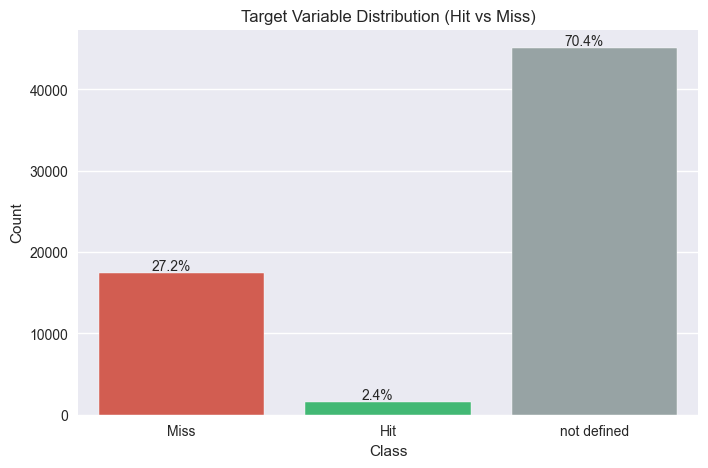

In [38]:
# visualize Target Distribution
plt.figure(figsize=(8, 5))
palette = {
    'Miss': '#E74C3C',        # red
    'Hit': '#2ECC71',         # green
    'not defined': '#95A5A6'  # gray
}

ax = sns.countplot(x='target_class', data=df, order=['Miss', 'Hit', 'not defined'], palette=palette, hue='target_class', legend=False)
plt.title('Target Variable Distribution (Hit vs Miss)')
plt.xlabel('Class')
plt.ylabel('Count')

# Add percentages
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()


## 4. Exploratory Data Analysis (EDA)

### Sales Distribution


C:\Users\MICROSOFT\PycharmProjects\data-mining-project\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


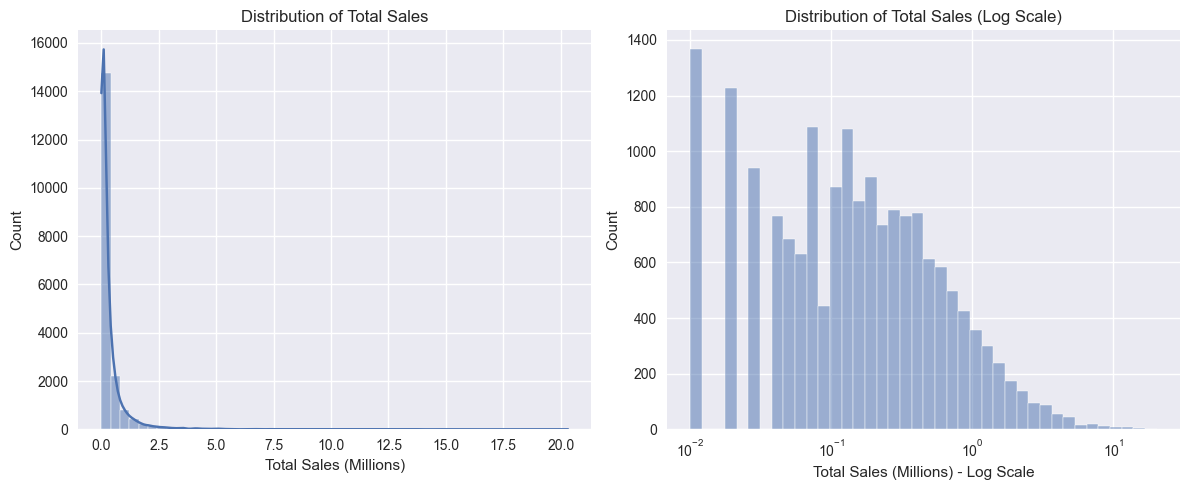

In [39]:
# histogram of Total Sales
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['total_sales'], bins=50, kde=True)
plt.title('Distribution of Total Sales')
plt.xlabel('Total Sales (Millions)')

# log scale histogram (to see the tail better)
plt.subplot(1, 2, 2)
sns.histplot(df['total_sales'], bins=40, kde=True, log_scale=True)
plt.title('Distribution of Total Sales (Log Scale)')
plt.xlabel('Total Sales (Millions) - Log Scale')

plt.tight_layout()
plt.show()


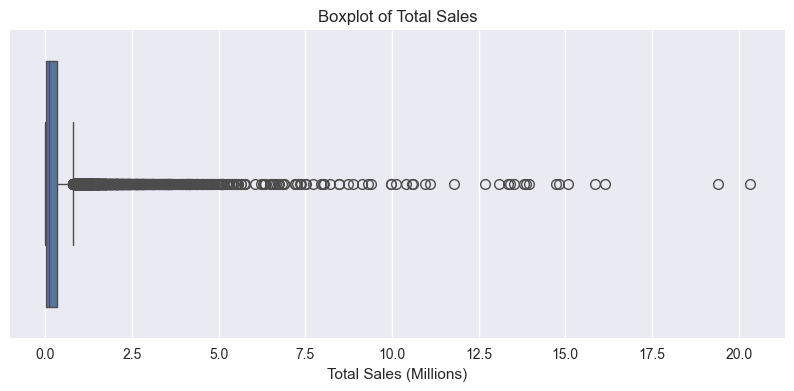

In [40]:
# boxplot of total sales
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['total_sales'])
plt.title('Boxplot of Total Sales')
plt.xlabel('Total Sales (Millions)')
plt.show()


### Console Distribution (Top 10)


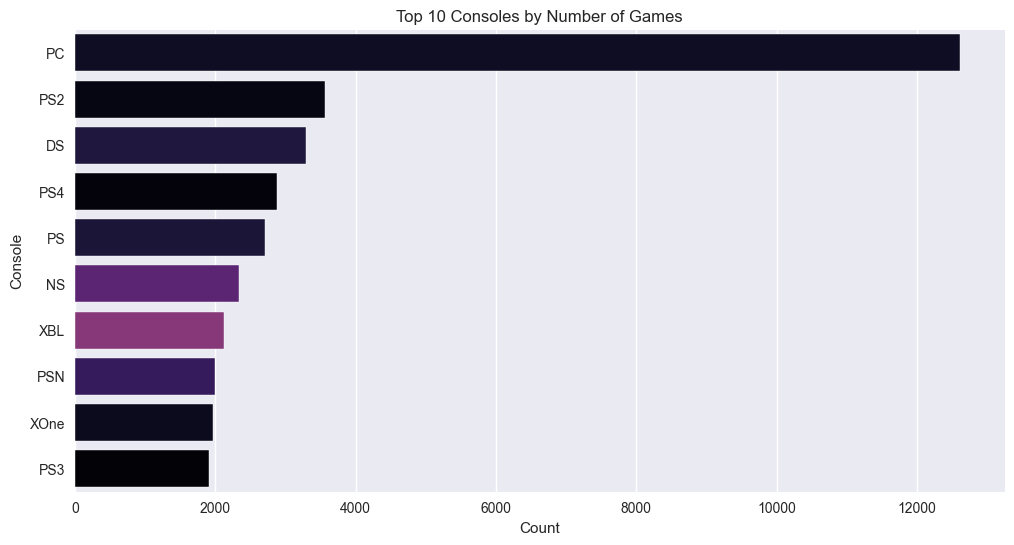

In [41]:
top_consoles = df['console'].value_counts().head(10).index

plt.figure(figsize=(12, 6))
sns.countplot(y='console', data=df, order=top_consoles, palette='magma', hue='console', legend=False)
plt.title('Top 10 Consoles by Number of Games')
plt.xlabel('Count')
plt.ylabel('Console')
plt.show()


### Publisher Distribution (Top 10)


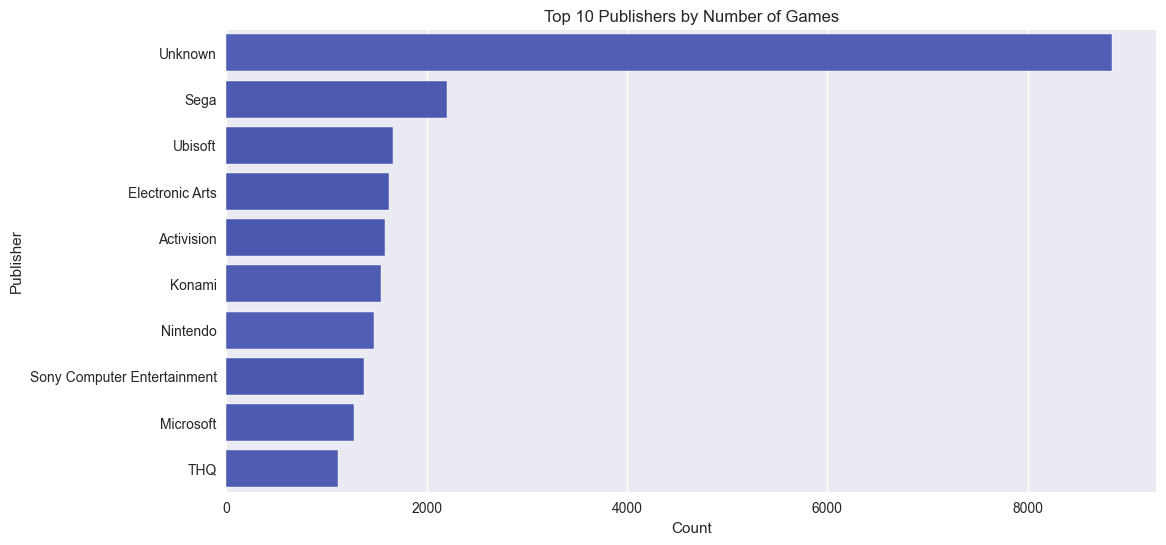

In [42]:
top_publishers = df['publisher'].value_counts().head(10).index

plt.figure(figsize=(12, 6))
sns.countplot(y='publisher', data=df, order=top_publishers, palette='coolwarm', hue='publisher', legend=False)
plt.title('Top 10 Publishers by Number of Games')
plt.xlabel('Count')
plt.ylabel('Publisher')
plt.show()


### Genre Distribution


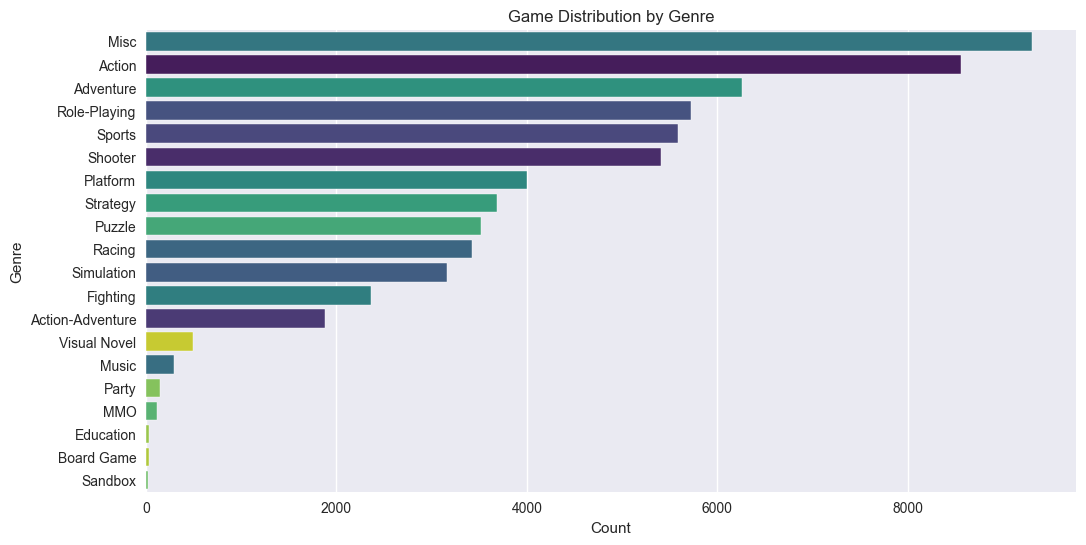

In [43]:
# Genre distribution
genre_counts = df['genre'].value_counts()

plt.figure(figsize=(12, 6))
sns.countplot(y='genre', data=df, order=df['genre'].value_counts().index, palette='viridis', hue='genre', legend=False)
plt.title('Game Distribution by Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


### Regional Sales Analysis



Total combined: 6601.41 million


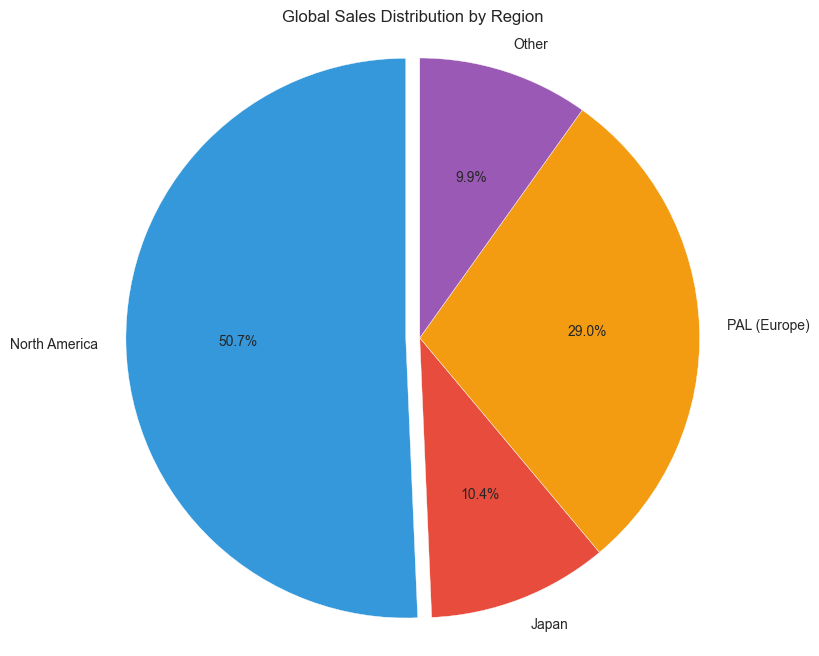

In [44]:
# Regional sales breakdown
regional_sales = df[['na_sales', 'jp_sales', 'pal_sales', 'other_sales']].sum()
print(f"\nTotal combined: {regional_sales.sum():.2f} million")

# Pie chart for regional sales
plt.figure(figsize=(10, 8))
colors = ['#3498DB', '#E74C3C', '#F39C12', '#9B59B6']
plt.pie(regional_sales, labels=['North America', 'Japan', 'PAL (Europe)', 'Other'],
        autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05, 0, 0, 0))
plt.title('Global Sales Distribution by Region')
plt.axis('equal')
plt.show()


### Sales by Console (Top 10)


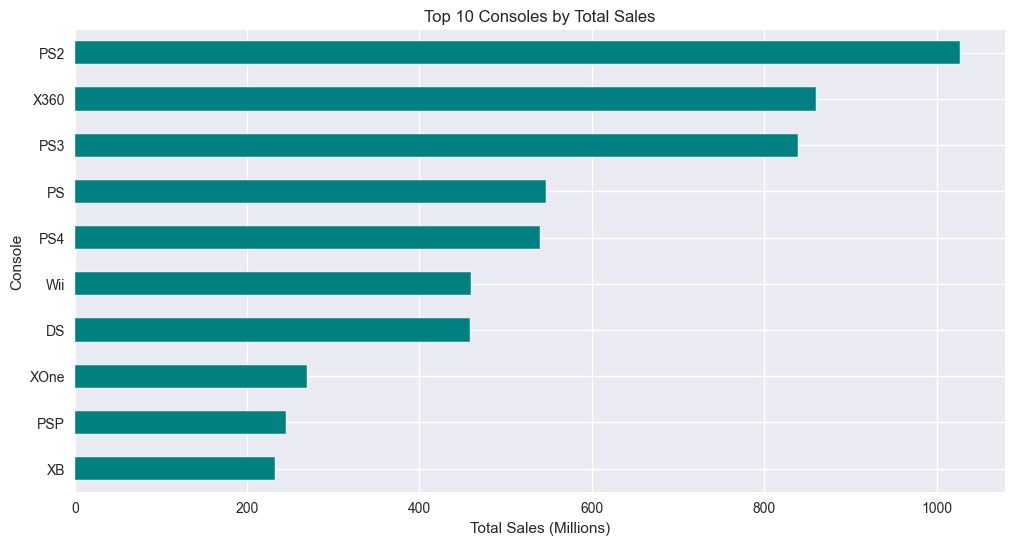

In [45]:
# Total sales per console
console_sales = df.groupby('console')['total_sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
console_sales.plot(kind='barh', color='teal')
plt.title('Top 10 Consoles by Total Sales')
plt.xlabel('Total Sales (Millions)')
plt.ylabel('Console')
plt.gca().invert_yaxis()
plt.show()


### Sales by Genre


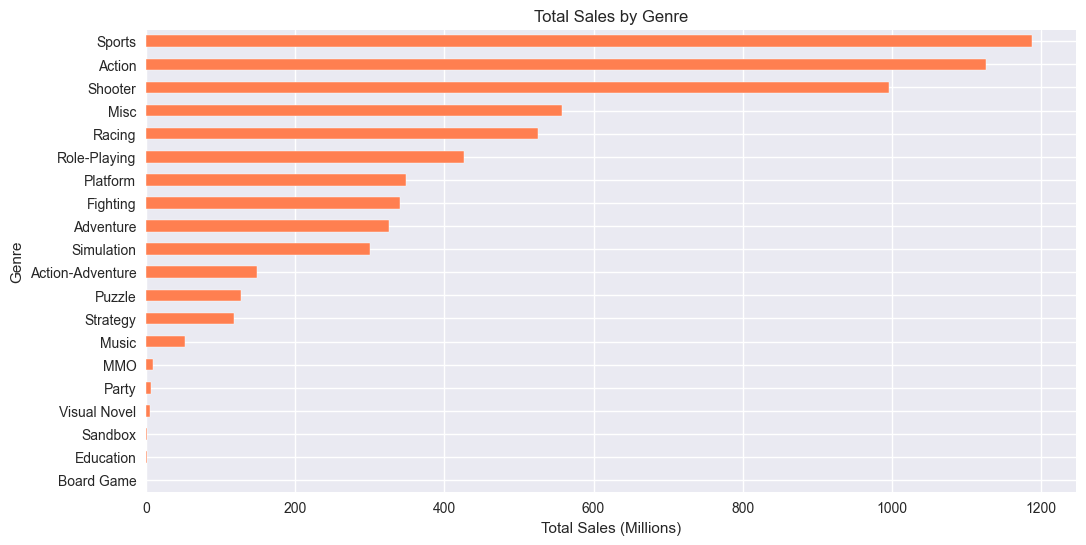

In [46]:
# Total sales per genre
genre_sales = df.groupby('genre')['total_sales'].agg(['sum', 'mean', 'count']).sort_values('sum', ascending=False)


plt.figure(figsize=(12, 6))
genre_sales['sum'].plot(kind='barh', color='coral')
plt.title('Total Sales by Genre')
plt.xlabel('Total Sales (Millions)')
plt.ylabel('Genre')
plt.gca().invert_yaxis()
plt.show()


### Developer Distribution (Top 10)


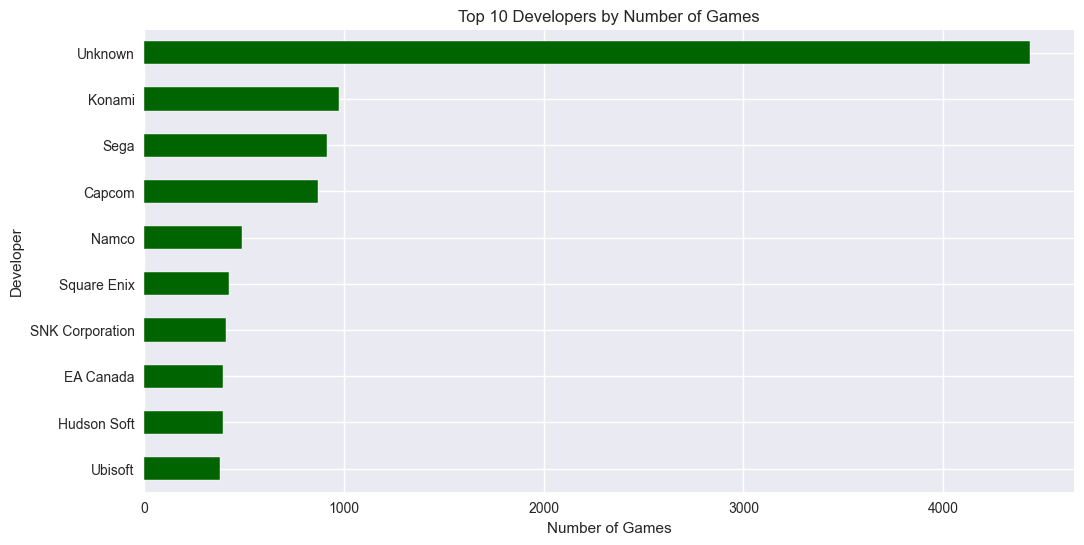

In [47]:
# Top developers
top_developers = df['developer'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_developers.plot(kind='barh', color='darkgreen')
plt.title('Top 10 Developers by Number of Games')
plt.xlabel('Number of Games')
plt.ylabel('Developer')
plt.gca().invert_yaxis()
plt.show()


### Correlation Analysis


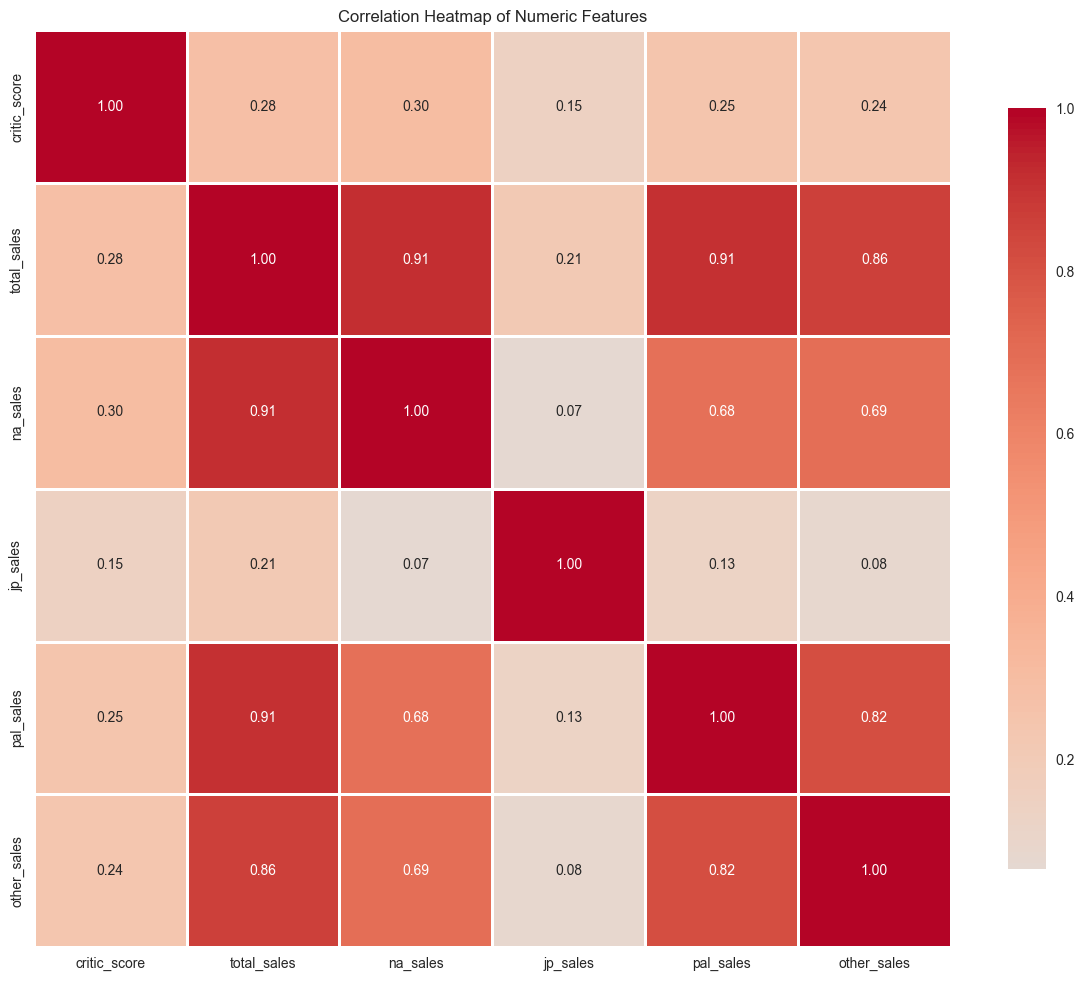

In [48]:
# Correlation matrix for numeric columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


### Additional: Critic Score vs Sales
Does a high critic score correlate with high sales?


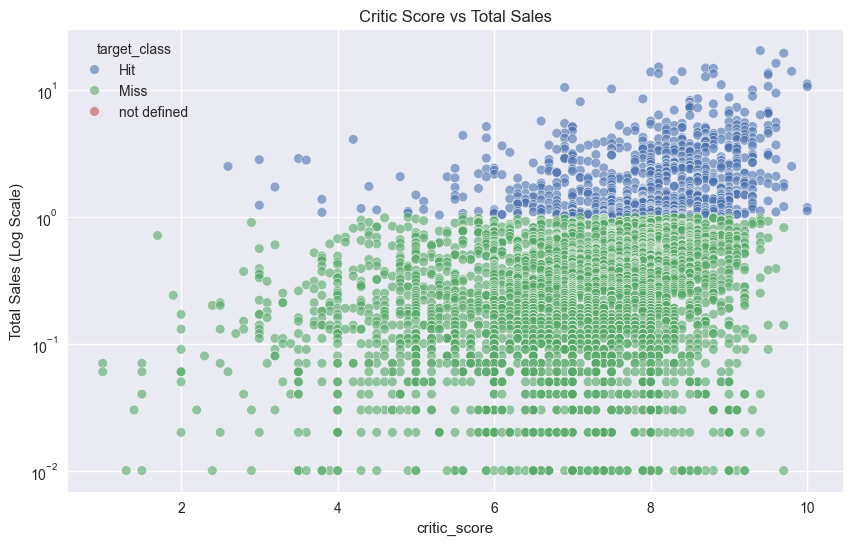

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='critic_score', y='total_sales', hue='target_class', data=df, alpha=0.6)
plt.title('Critic Score vs Total Sales')
plt.yscale('log') # Log scale for sales to see better
plt.ylabel('Total Sales (Log Scale)')
plt.show()


## 5. Insights & Key Findings

### 1. What consoles dominate?
(look at console distribution and sales)

### 2. Is sales distribution skewed?
*   **Observation**: Yes, **highly right-skewed**. Most games sell very few copies, while a few "blockbusters" sell millions
*   The log-scale histogram confirms this **power-law distribution**, which is typical in entertainment industries
*   This means the mean is pulled up by outliers, while the median is much lower

### 3. Is class imbalance severe?
*   **Observation**: The "Miss" class is significantly larger than the "Hit" class, indicating **significant class imbalance**
*   This needs to be addressed during modeling using:
  - Appropriate evaluation metrics (F1-score, precision-recall, ROC-AUC)
  - Resampling techniques (SMOTE, undersampling, or class weights)
  - Stratified cross-validation

### 4. Regional Sales Patterns
*   Different regions contribute differently to total sales
*   North America and PAL (Europe) regions typically dominate global sales
*   Japan has distinct preferences (more RPGs, handheld games)
*   This suggests regional features could be valuable predictors

### 5. Genre and Publisher Insights
*   Certain genres dominate in terms of quantity (Action, Sports, Misc)
*   Some genres may have higher average sales despite fewer titles
*   Major publishers (EA, Ubisoft, Activision) release more games but success varies
*   Publisher reputation could be a predictive feature

### 6. Missing Data Considerations
*   `critic_score` has significant missing values - common for older/indie games
*   `developer` and `last_update` may also have gaps
*   Strategy needed: imputation vs. exclusion vs. missingness as a feature

### 7. Correlation Findings
*   Regional sales are highly correlated with `total_sales` (as expected, since total = sum of regions)
*   `critic_score` may show positive correlation with sales but with high variance
*   Features need careful selection to avoid multicollinearity in modeling
